In [1]:
import time
import pennylane as qml
from pennylane import numpy as np
from matplotlib import pyplot as plt
from quantum.Quantum import QuantumRegressor
from quantum.Circuits import double_angle, entangle_cnot, mitarai, single_angle, rotation_layer, entangle_cz, composer
from quantum.Evaluate import evaluate_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score 

In [2]:
st = time.time()
# Generate random data
np.random.seed(4)  # Set seed for reproducibility
X = np.random.uniform(low=0, high=10, size=(100,))
y = np.sin(X / 2)

# Reshape X to (-1, 1)
X = X.reshape(-1, 1)

# Normalize the dataset between -1 and 1
scaler = MinMaxScaler(feature_range=(-0.9, 0.9))
X_normalized = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)


## Here we define all of the encoders we will use

Listing encoders to be used and compared i this notebook. This list is derived from Suzuki & Katouda DOI 10.1088/2399-6528/abd3d8

In [3]:
encoders = {
    'M': mitarai,
    'A1': single_angle,
    'A2': double_angle,
    'M-M-CNOT': composer(mitarai, entangle_cnot, mitarai, entangle_cnot),
    'A1-A1-CNOT': composer(single_angle, entangle_cnot, single_angle, entangle_cnot),
    'A2-A2-CNOT': composer(double_angle, entangle_cnot, double_angle, entangle_cnot),
    'M-A1-CNOT': composer(mitarai, entangle_cnot, single_angle, entangle_cnot), 
    'M-A2-CNOT': composer(mitarai, entangle_cnot, double_angle, entangle_cnot),
    'M-M-CZ': composer(mitarai, entangle_cz, mitarai, entangle_cz),
    'A1-A1-CZ': composer(single_angle, entangle_cz, single_angle, entangle_cz),
    'A2-A2-CZ': composer(double_angle, entangle_cz, double_angle, entangle_cz),
    'M-A1-CZ': composer(mitarai, entangle_cz, single_angle, entangle_cz),
    'M-A2-CZ': composer(mitarai, entangle_cz, double_angle, entangle_cz)
}


## Model training

Here we define the parameters of our model and a random set of initial parameters. Then we loop through each of the encoders and train the model for them and evaluate/plot it.

Starting on: M encoder...

Training completed taking  237.01346397399902 seconds

Starting on: A1 encoder...

Training completed taking  501.48714208602905 seconds

Starting on: A2 encoder...

Training completed taking  318.4656488895416 seconds

Starting on: M-M-CNOT encoder...

Training completed taking  572.7018477916718 seconds

Starting on: A1-A1-CNOT encoder...

Training completed taking  613.4537951946259 seconds

Starting on: A2-A2-CNOT encoder...

Training completed taking  692.9890558719635 seconds

Starting on: M-A1-CNOT encoder...

Training completed taking  593.484917640686 seconds

Starting on: M-A2-CNOT encoder...

Training completed taking  629.1575689315796 seconds

Starting on: M-M-CZ encoder...

Training completed taking  204.97369718551636 seconds

Starting on: A1-A1-CZ encoder...

Training completed taking  609.2588715553284 seconds

Starting on: A2-A2-CZ encoder...

Training completed taking  686.8312656879425 seconds

Starting on: M-A1-CZ encoder...

Training com

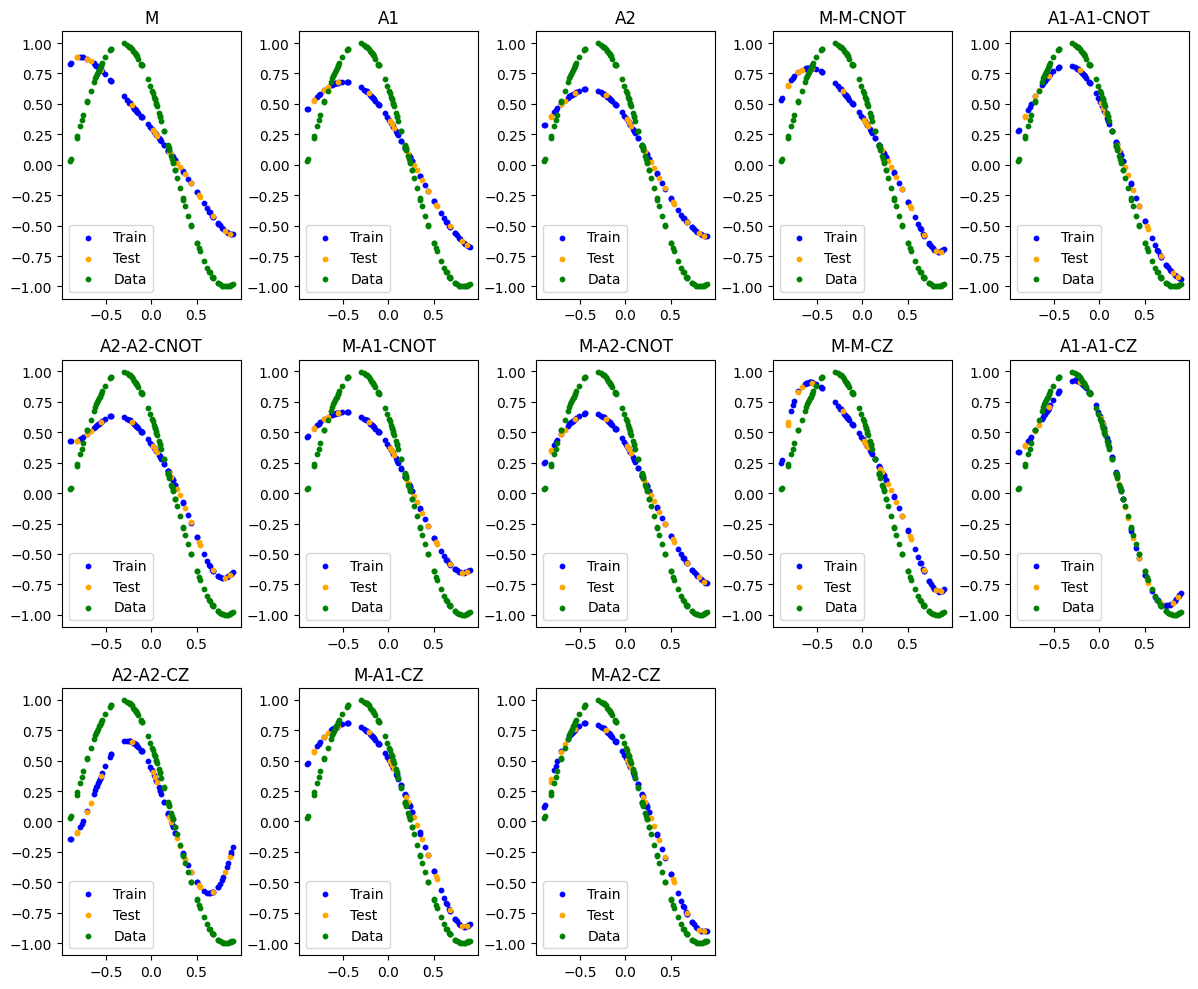

In [4]:
num_qubits = 3
layers = 3
initial_parameters = np.random.uniform(low=-1, high=1, size= 3 * 2 * num_qubits)
def variational(parameters, wires):
    num_qubits = len(wires)
    rotation_layer(parameters[:num_qubits *3], wires)
    entangle_cnot(wires)
    rotation_layer(parameters[num_qubits *3:num_qubits*3 *2], wires)
        
results = {}

fig = plt.figure(figsize=(12, 2*5), dpi=100)
n_cols = 5
n_rows = int(len(list(encoders.keys())) / n_cols) + 1
i=0

for name, encoder in encoders.items():
    print('Starting on:', name, 'encoder...\n')
    st = time.time()
    model = QuantumRegressor(encoder, variational, num_qubits)
    opt_results = model.fit(X_train, y_train, initial_parameters, detailed_results=True)
    et = time.time()
    print('Training completed taking ', et-st, 'seconds\n')
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    loss = evaluate_model(model, X_train, X_test, y_train, y_test, title=name)
    i += 1
    results[name] = [opt_results, loss]
plt.tight_layout()

In [6]:
for name, result in results.items():
    print('Name: ' + name)
    print('Opt result:', result[0])
    print('Loss functions:', result[1], '\n')

Name: M
Opt result:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.13719751703418925
       x: [ 3.144e-01  1.876e+00 ... -6.258e-01  1.594e-01]
    nfev: 493
   maxcv: 0.0
Loss functions: {'MSE_train': 0.13719751703418925, 'MSE_test': 0.13767774445532271, 'R2_train': 0.7240104713736535, 'R2_test': 0.6286137040823989} 

Name: A1
Opt result:  message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.07830267963610629
       x: [ 1.097e+00 -1.175e-01 ...  1.350e-01  7.432e-01]
    nfev: 1000
   maxcv: 0.0
Loss functions: {'MSE_train': 0.07830267963610629, 'MSE_test': 0.06580203732241881, 'R2_train': 0.842484615537441, 'R2_test': 0.8224987269969756} 

Name: A2
Opt result:  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.08984625127798258
       x: [ 1.985e+00  1.247e+00 ... -6.803e-01  6.664e-01]
    nfev: 590
   maxcv: 0.0
Loss functions: {'MSE_train': 0.08984625